# Read data

In [1]:
import pandas as pd
import numpy as np

daily_treasury_yield_curve_rate_df = pd.read_csv('daily_treasury_yield_curve_rate.csv',
                                                 parse_dates=['Date'], index_col='Date')
baa10y_df = pd.read_csv('BAA10Y.csv', parse_dates=['DATE'], index_col='DATE')

In [2]:
PERIODS = ['3 Mo','1 Yr','5 Yr','10 Yr','30 Yr']
FONT_SIZE = 10
FIGSIZE = (10,5)
TRAIN_START_DATE_1 ='1990-01-01'
TRAIN_END_DATE_1 = '2006-01-01'
TEST_START_DATE_1 = '2006-01-01'
TEST_END_DATE_1 = '2007-01-01'

TRAIN_START_DATE_2 ='2000-01-01'
TRAIN_END_DATE_2 = '2016-01-01'
TEST_START_DATE_2 = '2016-01-01'
TEST_END_DATE_2 = '2017-01-01'

In [3]:
def prepare_data(df, interest_periods, data_source,
                 start_date='1990-01-01', end_date = '2020-01-01',
                 fill=False, add_freq=False, freq='3m'):
    
    if data_source == 'yield':
        data = df[interest_periods]
    elif data_source == 'baa10y':
        data = df[interest_periods]
        data = data.replace('.',np.nan)
        data = data.dropna()
        data = data.astype(float)
        
    data = data.loc[start_date:end_date]
    data = data.sort_index(axis=0)

    if add_freq:
        data = data.asfreq(freq=freq)

    if fill:
        data = data.fillna(method='ffill')
        
    return data

In [4]:
def create_data_df(use, start_date, end_date):
    data_df = pd.DataFrame()
    for period in PERIODS:
        if use == 'std':
            data = prepare_data(daily_treasury_yield_curve_rate_df, 
                                interest_periods=period,
                                data_source='yield',
                                start_date=start_date,
                                end_date=end_date)
        elif use == 'seasonal_decompose':
            data = prepare_data(daily_treasury_yield_curve_rate_df,
                        interest_periods=period,
                        data_source='yield',
                        start_date=start_date,
                        end_date=end_date,
                        fill=True, add_freq=True, freq='3m')
        elif use == 'adfuller' or use == 'dataset':
            data = prepare_data(daily_treasury_yield_curve_rate_df,
                        interest_periods=period,
                        data_source='yield',
                        start_date=start_date,
                        end_date=end_date,
                        fill=True)
        data_df = add_data_to_df(data_df, period, data)
    if use == 'std':
        data = prepare_data(baa10y_df, 
                            interest_periods='BAA10Y', 
                            data_source='baa10y',
                            start_date=start_date, 
                            end_date=end_date)
    elif use == 'seasonal_decompose':
        data = prepare_data(baa10y_df,
                        interest_periods='BAA10Y',
                        data_source='baa10y',
                        start_date=start_date,
                        end_date=end_date,
                        fill=True, add_freq=True, freq='3m')
    elif use == 'adfuller' or use == 'dataset':
        data = prepare_data(baa10y_df,
                    interest_periods='BAA10Y',
                    data_source='baa10y',
                    start_date=start_date,
                    end_date=end_date,
                    fill=True)
    data_df = add_data_to_df(data_df, 'BAA10Y', data)
    
    return data_df

In [5]:
def add_data_to_df(df, header, data):
    df_to_add = pd.DataFrame(data={header: data})
    df = pd.concat([df, df_to_add], axis=1)
    return df

In [6]:
def old_plot_data(data, xlabel='', ylabel='', title=''):
    plt.figure(figsize=FIGSIZE)
    ax = plt.axes()
    ax.tick_params(axis='both', labelsize=FONT_SIZE)
    plt.xlabel(xlabel, fontdict={'size':FONT_SIZE})
    plt.ylabel(ylabel)
    plt.title(title)
    data.plot()
    
def plot_data(df, title):
    shape = df.shape[1]
    if shape%2==0:
        nrows=int(shape/2)
        ncols=2
    elif shape%3==0:
        nrows=int(shape/3)
        ncols=3
    else:
        nrows=shape
        ncols=1
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, dpi=120, figsize=(10,6))
    for i, ax in enumerate(axes.flatten()):
        data = df[df.columns[i]]
        ax.plot(data, linewidth=1)
    # Decorations
        ax.set_title(title + ' of ' + df.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=6)
    plt.tight_layout();

# 1.a Finding trend and seasonality

We can decompose time series to 3 main components: trend, seasonality, and noise (random vairable).
There are 2 main models that uses these components:

1. Additive model: y = trend + seasonality + noise
2. Multiplicative model: y = trend x seasonality x noise

In multiplicative model the variance of the seasonality is increasing (or decreasing) over time, while in additive model the varaince of the seasonality doesn't change much.
I used seasonal_decompose function (from statsmodels package) to decompose the time series into trend and seasonality. This function requires:

1. Model type. 
2. Frequency (which can be thought of as the seasonality)
3. No missing data. 

Due to this, I checked the rolling standart deviation of each time series to decide the model type. Furthermore, for seasonality  period of time of 1 quarter (3 months) is used. (The seasonality changes for different periods of time).

In this section, we were asked to work on data between 1990 to 2005.

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np

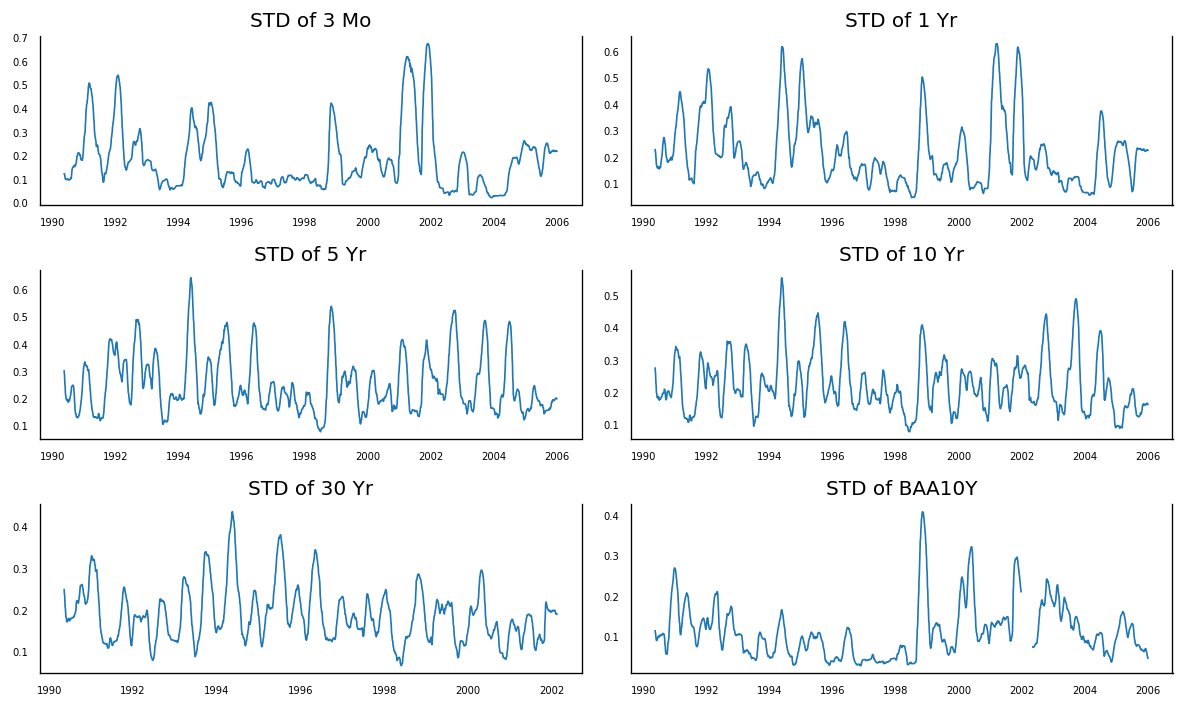

In [8]:
df_std = pd.DataFrame()
data_df = create_data_df(use='std', start_date=TRAIN_START_DATE_1, end_date=TRAIN_END_DATE_1) 

for name, series in data_df.iteritems():
    data = series.rolling(window=90).std()
    df_std = add_data_to_df(df_std, name, data)

plot_data(df_std, 'STD')

Since the standart deviation is not increasing or decresing over time, but volatile, *I chose to use the additive model*.

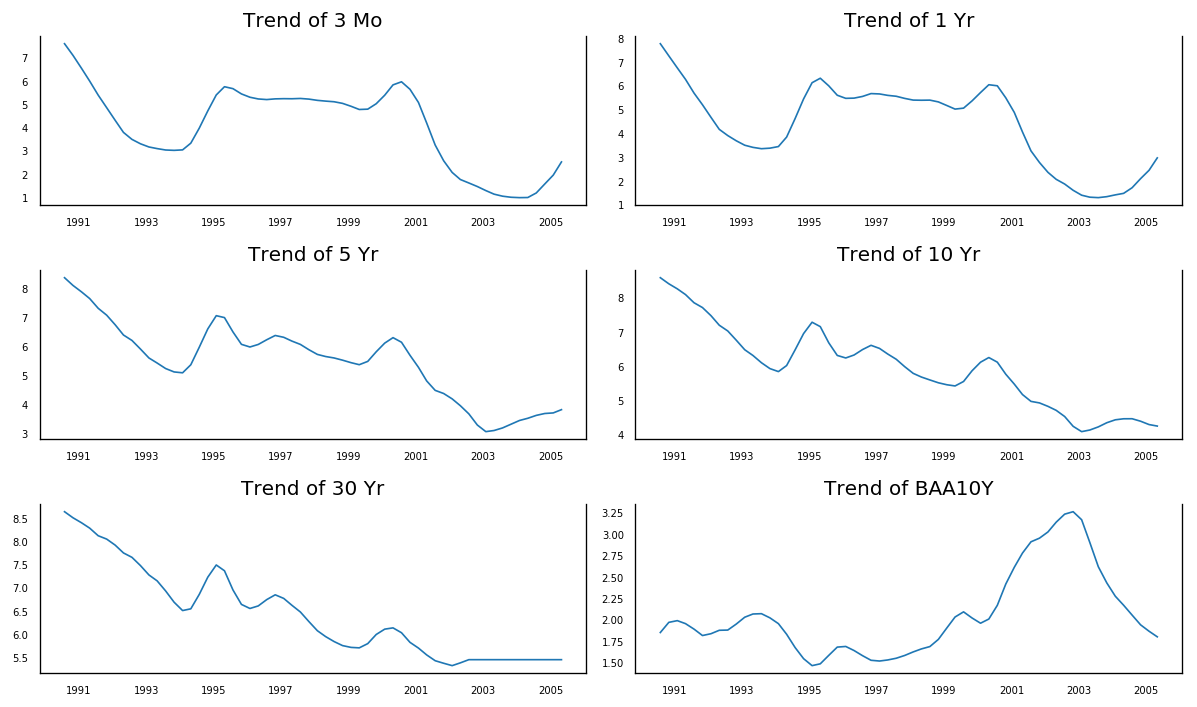

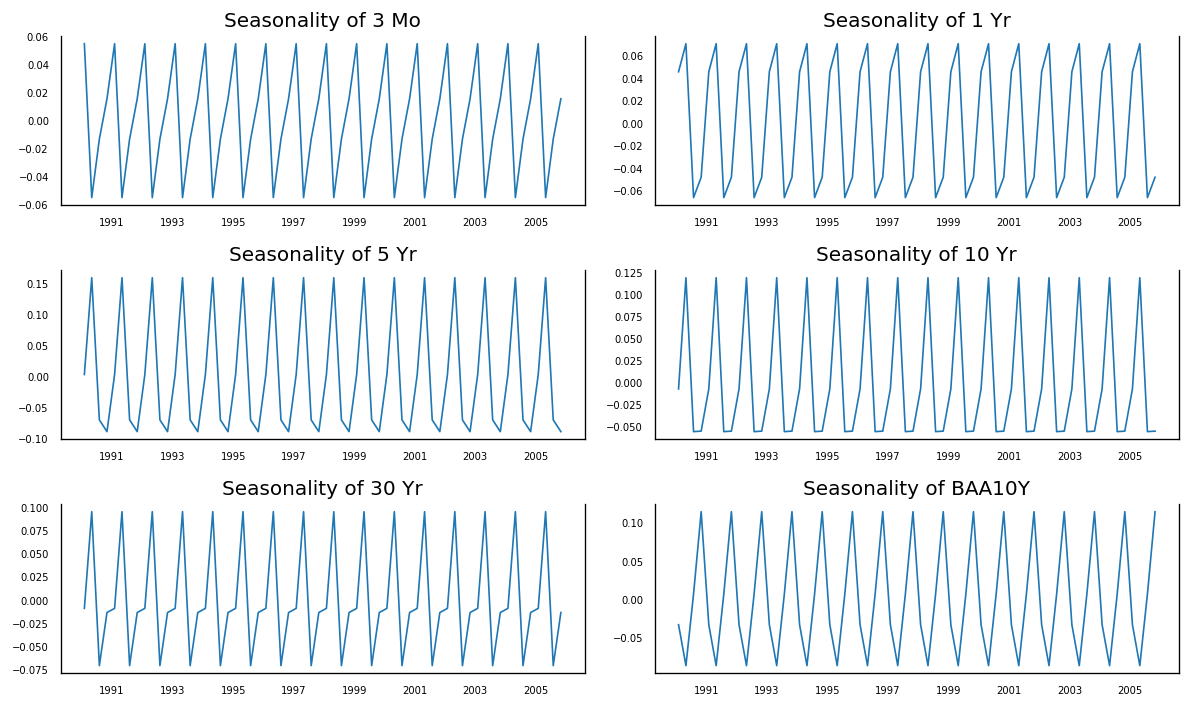

In [9]:
trend_df = pd.DataFrame()
seasonal_df = pd.DataFrame()
data_df = create_data_df(use='seasonal_decompose', start_date=TRAIN_START_DATE_1, end_date=TRAIN_END_DATE_1) 

for name, series in data_df.iteritems():
    result = seasonal_decompose(series, model='additive')
    trend_df = add_data_to_df(trend_df, name, result.trend)
    seasonal_df = add_data_to_df(seasonal_df, name, result.seasonal)

plot_data(trend_df, 'Trend')
plot_data(seasonal_df, 'Seasonality')

As can be seen, the trend is a smoothed average of the no risk interest.
The values of trend are between 1 to 8 while the values of seasonality are between -0.1 to 0.15, 
meaning the seasonality barely has any effect. It can be thought of that there is not seasonality for this period.

Furthermore, it can be seen that the interest rate of 30 years interest is constant 0 from ~2002. 
There is not any data for this interest between 2.2002 to 2.2006.
We need to take it into account when forecasting since in VAR model predictions of all time series are affected by the all other
time series. Meaning that the fact that the interest rate for 30 years is constant 0 for long time (at transformed data) will
affect the forecast of, for example, 3 month interest.

# 1.b Checking stationarity and unit root

The properties (definition) of (weak) stationarity time series is:

1. Constant mean: for all t: E[y(t)] = M
2. Auto covariance depends only on the diffrenece in time: for all u,v,k cov(y(u),y(v)) = cov(y(u+a),y(v+a))
    
It can be inferred from the definition that in stationary time series there isn''t trend or seasonality. 
In all periods there is a trend, so we can assume that all serieses are not stationary.

For formality, I used Augmented Dickey-Fuller test, which is a statisitcal method which checks if time series is stationary:
1. The null hypothesis (H0) suggests that the is a unit root, meaning the series is not stationary . 
The alternative hypothesis (H1) suggests that there is not an unit root and that the series is stationary.
2. We fail to reject H0 if p-value > 0.05. (non stationary). 
We reject H0 if p-value <= 0.05 (statonary)

In [10]:
from statsmodels.tsa.stattools import adfuller

In [11]:
train_df = create_data_df(use='adfuller', start_date=TRAIN_START_DATE_1, end_date=TRAIN_END_DATE_1) 
train_df = train_df.drop(columns=['30 Yr'])
train_df = train_df.dropna()

test_df = create_data_df(use='dataset', start_date=TEST_START_DATE_1, end_date=TEST_END_DATE_1)
test_df = test_df.drop(columns=['30 Yr'])
test_df = test_df.dropna()

In [12]:
for name, series in train_df.iteritems():
    result = adfuller(series.values)
    p_value = result[1]
    
    print('p-value for period {period} is: {p_value}'.format(period=name, p_value=p_value))
    if p_value <= 0.05:
        print('Time series of no risk interest for {period} is stationary with no unit root\n'.
              format(period=name))
    else:
        print('Time series of no risk interest for {period} is not stationary and there is a unit root\n'.
              format(period=name))

p-value for period 3 Mo is: 0.21646900899987137
Time series of no risk interest for 3 Mo is not stationary and there is a unit root

p-value for period 1 Yr is: 0.22772218425521695
Time series of no risk interest for 1 Yr is not stationary and there is a unit root

p-value for period 5 Yr is: 0.4394758145341298
Time series of no risk interest for 5 Yr is not stationary and there is a unit root

p-value for period 10 Yr is: 0.5053310568860641
Time series of no risk interest for 10 Yr is not stationary and there is a unit root

p-value for period BAA10Y is: 0.24114541439083315
Time series of no risk interest for BAA10Y is not stationary and there is a unit root



# 1.c Co-Integration test

Before applying the Co-integration test we need to transform each time series to a stationary time series.
It can be done by trnasforming the time series to the 1 lag difference time series: 
y_t = x_t - x_t-1 (where x is the original time series and x_t is the value of the series at time t).

In [13]:
stationary_train_df = pd.DataFrame()
for name, series in train_df.iteritems():
    series_diff = series.diff(periods=1)
    series_diff = series_diff.dropna()
    result = adfuller(series_diff.values)
    p_value = result[1]
    print('p_value of period {period}: {p_value}'.format(period=name, p_value=p_value))
    if p_value < 0.05:
        print('stationary')
        data_to_add_df = pd.DataFrame(data = {name: series_diff})
        stationary_train_df = pd.concat([stationary_train_df,data_to_add_df], axis=1)
    else:
        print('not stationary')
        
stationary_test_df = test_df.diff(periods=1).dropna()

p_value of period 3 Mo: 4.9472896466929466e-17
stationary
p_value of period 1 Yr: 1.566922131447192e-18
stationary
p_value of period 5 Yr: 0.0
stationary
p_value of period 10 Yr: 0.0
stationary
p_value of period BAA10Y: 6.385803577854462e-24
stationary


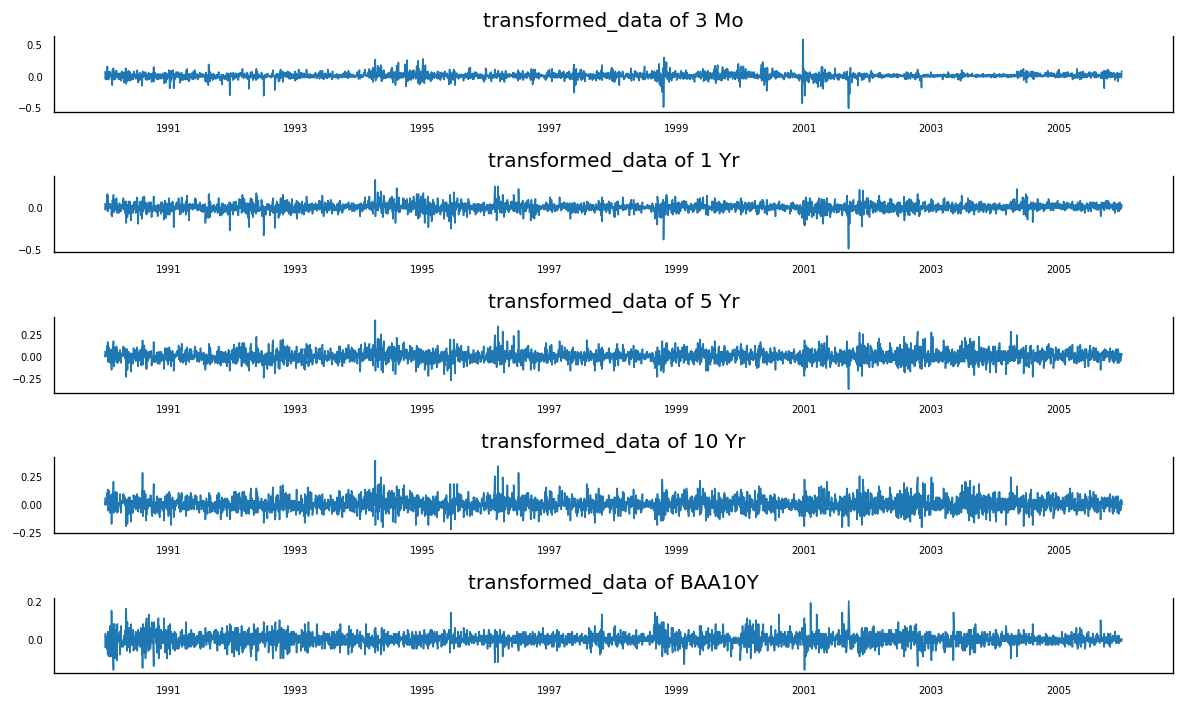

In [14]:
plot_data(stationary_train_df, 'transformed_data')

Now that the data is stationary we can check if co-integration exists using johansen test.
I applied the test for 10 lags.

In [15]:
from statsmodels.tsa.vector_ar.vecm import select_coint_rank
LAGS = 11

# stationary_train_df = stationary_train_df.drop(columns=['30 Yr'])
for lag in range(1,LAGS):
    print("lag = {lag}".format(lag=lag))
    print('#'*50)
    res = select_coint_rank(stationary_train_df, 1, lag, method='trace')
    print(res.summary())

lag = 1
##################################################
Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   5          8735.          79.34
  1   5          6602.          55.25
  2   5          4756.          35.01
  3   5          3091.          18.40
  4   5          1511.          3.841
-------------------------------------
lag = 2
##################################################
Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   5          6393.          79.34
  1   5          4780.          55.25
  2   5          3450.          35.01
  3   5          2201.          18.40
  4   5          1076.          3.841
-------------------------------------
lag = 3
##################################################
Johansen cointegration test using trace test statis

# 1.d

It can be seen that for each lag in the specified lag range the johansen output the hishest possible rank:
For each rank the test statistic is higher than the critical value.
Now we can use a VAR (Vector auto regressive) model to predict future values.
For each lag we are constructing different model and we need to chose most appropriate model according to some criteria.
I chose AIC criteria.

In [16]:
import statsmodels.tsa.api as smt
from statsmodels.tsa.api import VAR


mod = smt.VAR(stationary_train_df)
lag_results = mod.select_order(maxlags=LAGS)
chosen_lag = lag_results.selected_orders['aic']
fitted_model = mod.fit(maxlags=chosen_lag)
# print(lag_results.summary())
# print(fitted_model.summary())

C:\Users\noamarbe\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


We can use Durbin–Watson statistic in order to detect if there is auto correlation at lag 1 of the prediction errors (residuals)
from regression analysis. The null hypothesis states that the residuals are uncorrelated and the alternative hypothesis stated that
the residuals follow first order auto regressive process. 
The value of the test statistic, d, is between 0 to 4.
d < 2: postive serial correlation
d > 2: negative serial correlation
d=2: no auto correlation


In [17]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(fitted_model.resid)

for col, val in zip(stationary_train_df.columns, out):
    print((col), ':', round(val,2))

3 Mo : 2.0
1 Yr : 1.99
5 Yr : 2.0
10 Yr : 2.0
BAA10Y : 2.0


We can use the fitted model in order to forecast future values

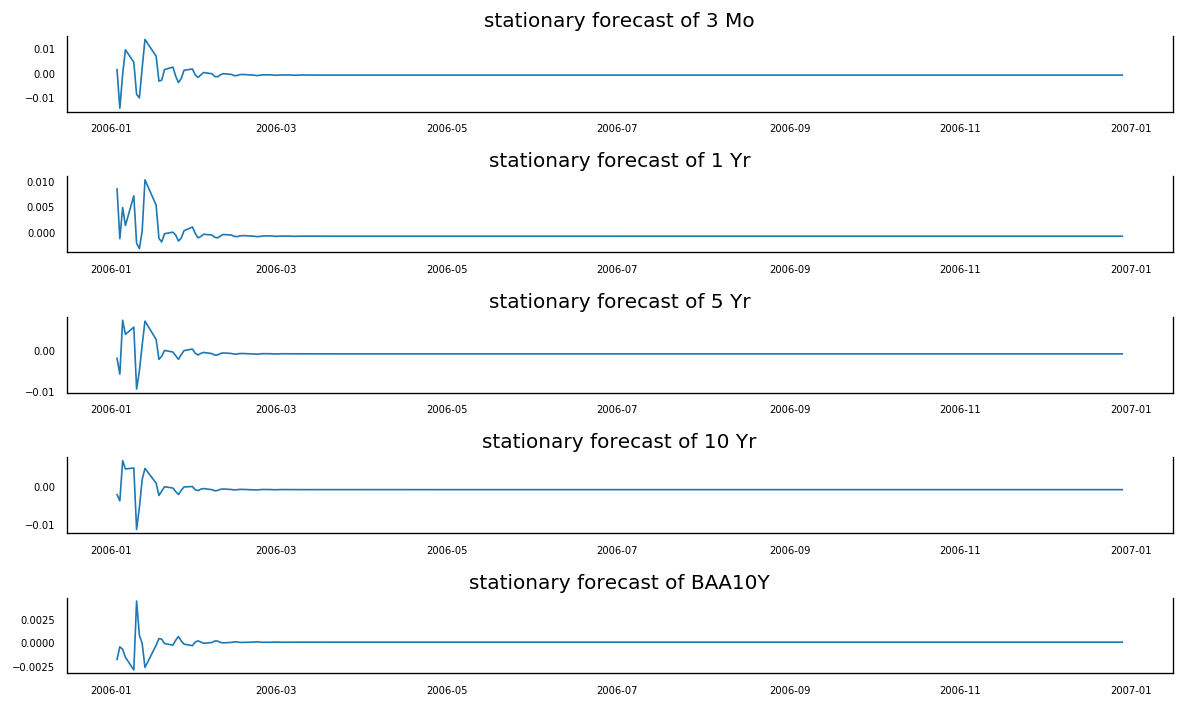

In [18]:
forecast = fitted_model.forecast(stationary_train_df.values[-chosen_lag:],test_df.shape[0])
forecast_df = pd.DataFrame(data=forecast, columns=stationary_train_df.columns)
forecast_df.index = test_df.index
plot_data(forecast_df, 'stationary forecast')

In order to evaluate our prediction we need to transform the data to its original form. In previous stage we transformed the data to stationary data using 1 period difference series. (y_t = x_t - x_t-1)
We need to obtain x_t from y_t: 

x_t = y_t + x_t-1 and x_t-1 = y_t-1 + x_t-2 

x_t = y_t + y_t-1 + x_t-2 and x_t-2 = y_t-2 + x_t-3 

x_t = y_t + y_t-1 + y_t-2 + x_t-3 
...

In order to get x_t we need calculate the cumulative sum of all previous samples from the stationary data plus the first sample from the original data. 

In [19]:
def transfrom_from_stationary(stationary_df, train_sample):
    df = pd.DataFrame()
    for col in stationary_df.columns:
        df[col] = train_sample[col] + stationary_df[col].cumsum()
    return df

In [20]:
def plot_prediction(forecast_df,train_sample,chosen_columns=None):
    forecast_df = transfrom_from_stationary(forecast_df, train_sample)
    if chosen_columns is None:
        chosen_columns = forecast_df.columns
    for col in chosen_columns:
        _df = pd.concat([forecast_df[col], test_df[col]], axis=1)
        _df.columns = ['prediction {}'.format(col), 'actual {}'.format(col)]
        _df.plot()

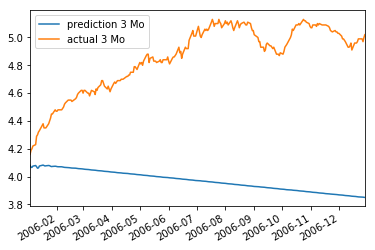

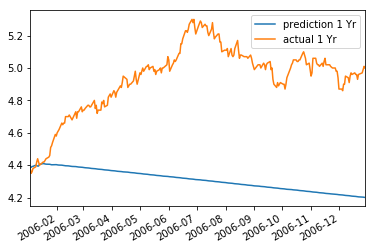

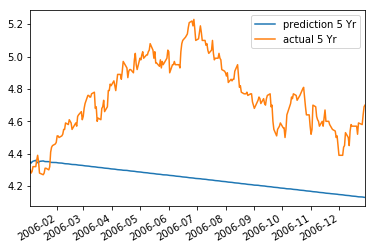

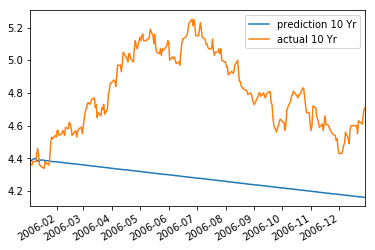

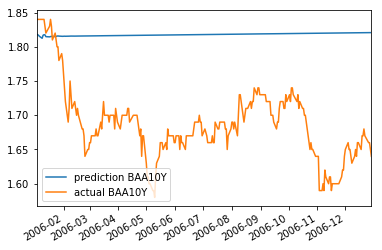

In [21]:
train_sample = train_df.iloc[-1]
plot_prediction(forecast_df,train_sample)

It can be seen from the forcast results that after several steps the forecast is constant 
and does not give any additional information.
We can use this forecast or try predict in iterative way, when each time we predict only the next lag (3) observations.

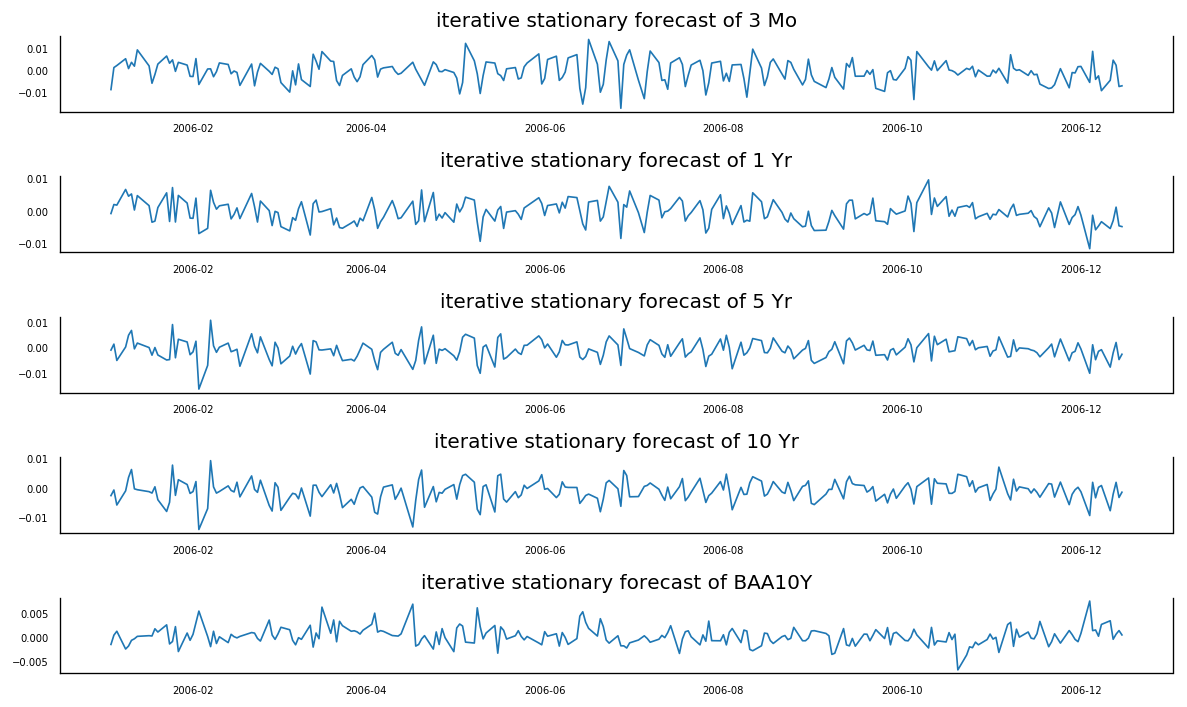

In [22]:
iterative_forecast_df = pd.DataFrame()
date_series = pd.Series()
nobs = stationary_test_df.shape[0]
for idx in range(0,nobs,chosen_lag):
    s_idx = idx
    f_idx = min(nobs, idx + chosen_lag)
    inner_stationary_test_df = stationary_test_df.iloc[s_idx: f_idx]
    if inner_stationary_test_df.shape[0] == chosen_lag:
        date = inner_stationary_test_df.index.values
        date = pd.Series(date)
        forecast = fitted_model.forecast(inner_stationary_test_df.values,chosen_lag)
        inner_forecast_df = pd.DataFrame(data=forecast, columns=stationary_test_df.columns)
        iterative_forecast_df = pd.concat([iterative_forecast_df, inner_forecast_df], axis=0)
        date_series = pd.concat([date_series, date],axis=0)
iterative_forecast_df.index = date_series.values   
plot_data(iterative_forecast_df, 'iterative stationary forecast')

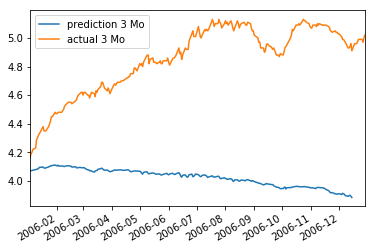

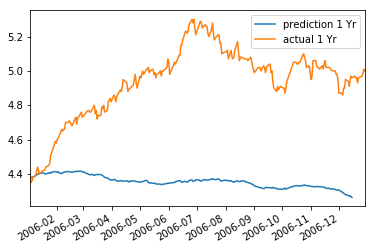

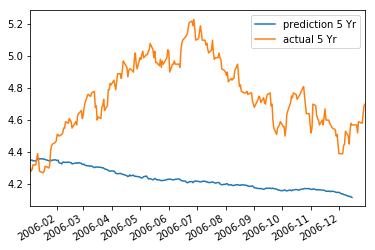

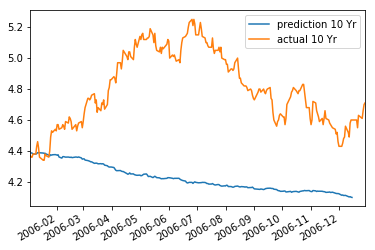

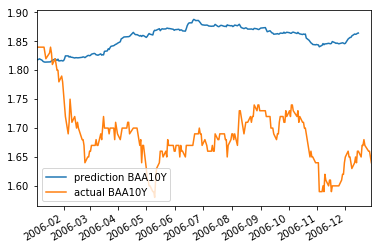

In [23]:
plot_prediction(iterative_forecast_df,train_sample)

Both ways did not yield good results.

In [31]:
train_df = create_data_df(use='adfuller', start_date=TRAIN_START_DATE_1, end_date=TRAIN_END_DATE_1) 
train_df = train_df.dropna()

test_df = create_data_df(use='dataset', start_date=TEST_START_DATE_1, end_date=TEST_END_DATE_1)
test_df = test_df.dropna()

stationary_train_df = train_df.diff(periods=1).dropna()
stationary_test_df = test_df.diff(periods=1).dropna()

C:\Users\noamarbe\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


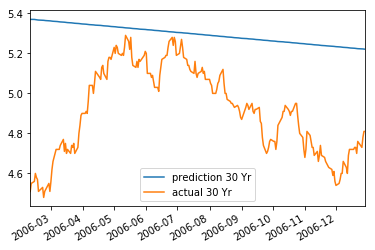

In [32]:
mod = smt.VAR(stationary_train_df)
lag_results = mod.select_order(maxlags=LAGS)
chosen_lag = lag_results.selected_orders['aic']
fitted_model = mod.fit(maxlags=chosen_lag)
forecast = fitted_model.forecast(stationary_train_df.values[-chosen_lag:],test_df.shape[0])
forecast_df = pd.DataFrame(data=forecast, columns=stationary_train_df.columns)
forecast_df.index = test_df.index
train_sample = train_df.iloc[-1]
plot_prediction(forecast_df,train_sample,['30 Yr'])

In [29]:
# iterative_forecast_df = pd.DataFrame()
# date_series = pd.Series()
# nobs = stationary_test_df.shape[0]
# updated_stationary_train_df = stationary_train_df

# for idx in range(0,nobs,chosen_lag):
#     s_idx = idx
#     f_idx = min(nobs, idx + chosen_lag)
#     inner_stationary_test_df = stationary_test_df.iloc[s_idx: f_idx]
#     if inner_stationary_test_df.shape[0] == chosen_lag:
#         date = inner_stationary_test_df.index.values
#         date = pd.Series(date)
        
#         updated_stationary_train_df = pd.concat([updated_stationary_train_df,inner_stationary_test_df], axis=0)
#         mod = smt.VAR(updated_stationary_train_df)
# #         lag_results = mod.select_order(maxlags=LAGS)
# #         chosen_lag = lag_results.selected_orders['aic']
#         fitted_model = mod.fit(maxlags=chosen_lag)
        
#         forecast = fitted_model.forecast(inner_stationary_test_df.values,chosen_lag)
#         inner_forecast_df = pd.DataFrame(data=forecast, columns=stationary_test_df.columns)
#         iterative_forecast_df = pd.concat([iterative_forecast_df, inner_forecast_df], axis=0)
#         date_series = pd.concat([date_series, date],axis=0)
# iterative_forecast_df.index = date_series.values   
# plot_data(iterative_forecast_df, ' ')

In [30]:
# train_sample = data_df.iloc[-1]
# predict_df = transfrom_from_stationary(iterative_forecast_df, train_sample)
# for col in predict_df.columns:
#     _df = pd.concat([predict_df[col], test_df[col]], axis=1)
#     _df.plot()